# ARIMA example 2

This notebook is strongly inspired [from Modern Pandas (Part 7)](https://tomaugspurger.github.io/modern-7-timeseries) by Tom Augspurger (Anaconda, Inc).

https://github.com/TomAugspurger

https://www.linkedin.com/in/tom-augspurger-01269315/

https://twitter.com/tomaugspurger

Also, some nice notebooks can be found on the StatsModels [website](http://www.statsmodels.org/dev/examples/index.html#statespace). Other nice notebooks about time series forecasting [here](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/) and [here](https://github.com/josef-pkt/pages/blob/gh-pages/slides/slides_forecasting.ipynb).

## Commercial and Non Commercial Flights per Month, Port Authority of NY NJ: Beginning 1977

Data found on [data.world](https://data.world/data-ny-gov/gy9h-ebus). Can also be found [here](https://data.ny.gov/Transportation/Commercial-and-Non-Commercial-Flights-per-Month-Po/gy9h-ebus).

Short description:
> The dataset presented in this forum is monthly data. The Port Authority collects monthly data for domestic and international cargo, flights, passengers and aircraft equipment type from each carrier at PANYNJ-operated airports. The data is aggregated and forms the basis for estimating flight fees, parking, concession, and PFC revenues at the Port Authority Airports.

The `.csv` file has 6 columns: `Airport Code`, `Year`, `Month`, `Domestic Flights`, `International Flights`, `Total Flights`. Here is the head of the file:

```
Airport Code,Year,Month,Domestic Flights,International Flights,Total Flights
ACY,2015,Jan,831,1,832
ACY,2015,Feb,785,1,786
ACY,2015,Mar,907,3,910
ACY,2015,Apr,901,3,904
ACY,2015,May,964,16,980
```

### Imports

In [1]:
import sys
print("Python version: {}".format(sys.version))
from datetime import datetime

import matplotlib
print("Matplotlib version: {}".format(matplotlib.__version__))
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
print("Numpy version: {}".format(np.__version__))

import pandas as pd
print("Pandas version: {}".format(pd.__version__))

import statsmodels
print("StatsModels version: {}".format(statsmodels.__version__))
import statsmodels.tsa.api as smta
import statsmodels.tsa.stattools as smts
import statsmodels.formula.api as smfa

import seaborn as sns
print("Seaborn version: {}".format(sns.__version__))

import pyramid
print("Pyramid version: {}".format(pyramid.__version__))
from pyramid.arima import auto_arima  # 0.6.5, pip install pyramid-arima

Python version: 3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]
Matplotlib version: 2.2.2
Numpy version: 1.14.3
Pandas version: 0.23.0
StatsModels version: 0.9.0
Seaborn version: 0.8.1
Pyramid version: 0.6.5


### Loading the data

In [2]:
flights = pd.read_csv('../../data/commercial-and-non-commercial-flights-per-month-port-authority-of-ny-nj-beginning-1977-1.csv')
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 6 columns):
Airport Code             1572 non-null object
Year                     1572 non-null int64
Month                    1572 non-null object
Domestic Flights         1572 non-null int64
International Flights    1572 non-null int64
Total Flights            1572 non-null int64
dtypes: int64(4), object(2)
memory usage: 73.8+ KB


How many different airports do we have here?

In [3]:
flights['Airport Code'].unique().tolist()

['ACY', 'EWR', 'JFK', 'LGA', 'SWF']

How many domestic and internal flights?

In [4]:
for col in ['Domestic Flights', 'International Flights']:
    print(flights[col].sum(), col)

32044873 Domestic Flights
6701119 International Flights


Renaming the column names to a shorter lower case format:

In [5]:
flights.columns = ['code', 'year', 'month', 'domestic', 'international', 'total']

### Creating a DateTimeIndex

In [6]:
flights['day'] = 1  # day arbitrarily set to first day
flights.month = pd.to_datetime(flights.month, format='%b').dt.month  # convert month from name to int
flights.index = pd.to_datetime(flights[['year', 'month', 'day']]) # create/set datetime index
flights.drop(['year', 'month', 'day'], axis=1, inplace=True)   # drop obsolete columns
flights.head(2)

,code,domestic,international,total
2015-01-01,ACY,831,1,832
2015-02-01,ACY,785,1,786


In [7]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1572 entries, 2015-01-01 to 2006-12-01
Data columns (total 4 columns):
code             1572 non-null object
domestic         1572 non-null int64
international    1572 non-null int64
total            1572 non-null int64
dtypes: int64(3), object(1)
memory usage: 61.4+ KB


Let us plot the JFK flights for example:

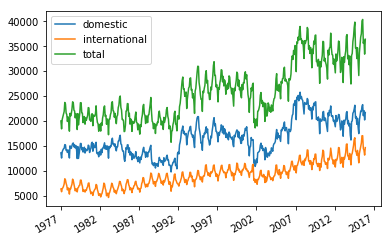

In [8]:
flights[flights.code == 'JFK'].plot()

### Merging all NY-NJ airports data

In [9]:
flights.drop(['code'], axis=1, inplace=True) 
flights = flights.groupby(flights.index).sum()

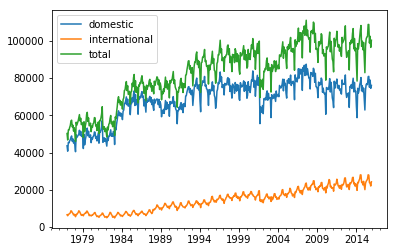

In [10]:
flights.plot()

In [11]:
flights.head(2)

,domestic,international,total
1977-01-01,43656,6587,50243
1977-02-01,40739,6027,46766


In [12]:
flights.tail(2)

,domestic,international,total
2015-11-01,74519,22014,96533
2015-12-01,76082,24299,100381


## Analysis

We are going to ckeck if the given time series `flights.total` do exhibit some of the following features:
* multicollinearity,
* autocorrelation,
* non-stationarity,
* seasonality.

### Multicollinearity

A basic idea of time series forecasting may be expressed as a typical regression problem, where we want to predict some values using a linear combination of the lagged (past) values. Let us create a dataframe with lagged values:

In [13]:
n_lags = 100
X = (pd.concat([flights.total.shift(i) for i in range(n_lags)], axis=1,
               keys=['total'] + ['L%s' % i for i in range(1, n_lags)]).dropna())
X['ones'] = 1.0  # for the constant term in the regression
X.head()

,total,L1,L2,L3,L4,L5,L6,L7,L8,L9,...,L91,L92,L93,L94,L95,L96,L97,L98,L99,ones
1985-04-01,72885,72309.0,66128.0,72924.0,72113.0,71239.0,75927.0,73310.0,78169.0,76454.0,...,53810.0,57424.0,56933.0,54568.0,53472.0,52114.0,52180.0,46766.0,50243.0,1.0
1985-05-01,77261,72885.0,72309.0,66128.0,72924.0,72113.0,71239.0,75927.0,73310.0,78169.0,...,54698.0,53810.0,57424.0,56933.0,54568.0,53472.0,52114.0,52180.0,46766.0,1.0
1985-06-01,75465,77261.0,72885.0,72309.0,66128.0,72924.0,72113.0,71239.0,75927.0,73310.0,...,51534.0,54698.0,53810.0,57424.0,56933.0,54568.0,53472.0,52114.0,52180.0,1.0
1985-07-01,80289,75465.0,77261.0,72885.0,72309.0,66128.0,72924.0,72113.0,71239.0,75927.0,...,53343.0,51534.0,54698.0,53810.0,57424.0,56933.0,54568.0,53472.0,52114.0,1.0
1985-08-01,81982,80289.0,75465.0,77261.0,72885.0,72309.0,66128.0,72924.0,72113.0,71239.0,...,50247.0,53343.0,51534.0,54698.0,53810.0,57424.0,56933.0,54568.0,53472.0,1.0


If we try to use the ordinary least squares method to perform the linear regression, we will have to invert the following matrix:
$$M = X^T X.$$
If there is an exact linear relationship among the independent variables, at least one of the columns of $X$ is a linear combination of the others. Then $X$ is rank deficient (it does not have full rank of `n_lags`+1). Then the matrix $M$ will not be invertible. 
In our case, we have an approximate colinearity, which still leads to numericaly singular matrix $M$ (very large condition number):

In [14]:
M = np.matmul(np.transpose(X.values), X.values)

In [15]:
M.shape

(101, 101)

In [16]:
np.linalg.cond(M)

121933134782116.17

Note that we did not scale the data, which probably make this condition number really worse...

Anyway, coefficients resulting from the regression would probably be useless, because lagged values are highly correlated with each others, especially the yearly lagged ones:

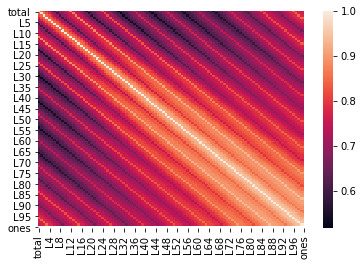

In [17]:
sns.heatmap(X.corr())

This will be confirmed in the next section.

### Autocorrelation

Nice explaination from the NIST's [Engineering Statistics Handbook](https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm):

> Autocorrelation plots (Box and Jenkins, pp. 28-32) are a commonly-used tool for checking randomness in a data set. This randomness is ascertained by computing autocorrelations for data values at varying time lags. If random, such autocorrelations should be near zero for any and all time-lag separations. If non-random, then one or more of the autocorrelations will be significantly non-zero.

Pandas has an autocorrelation plotting feature:

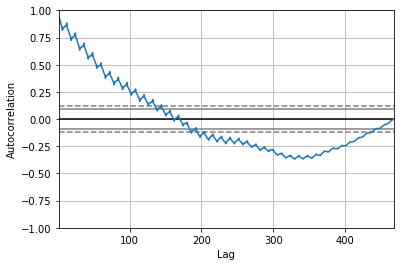

In [18]:
pd.plotting.autocorrelation_plot(flights.total)

The data is definitely not random. There is a significant positive correlation with the first 130 lags or so...

StatsModels also has some autocorrelation and partial autocorrelation plotting features:

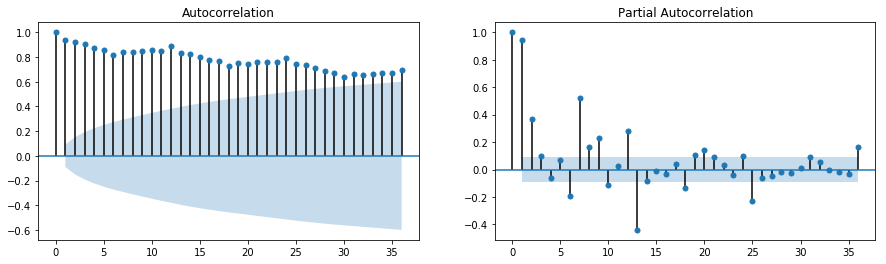

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = smta.graphics.plot_acf(flights.total, lags=36, ax=axes[0])
fig = smta.graphics.plot_pacf(flights.total, lags=36, ax=axes[1])

From [wikipedia](https://en.wikipedia.org/wiki/Partial_autocorrelation_function):

> In time series analysis, the partial autocorrelation function (PACF) gives the partial correlation of a time series with its own lagged values, controlling for the values of the time series at all shorter lags. It contrasts with the autocorrelation function, which does not control for other lags.

> This function plays an important role in data analysis aimed at identifying the extent of the lag in an autoregressive model. The use of this function was introduced as part of the Box–Jenkins approach to time series modelling, whereby plotting the partial autocorrelative functions one could determine the appropriate lags p in an AR (p) model or in an extended ARIMA (p,d,q) model.

Here there is no real clear appropriate lags $p$...

However, as Tom Augspurger explains in his notebook:

> Autocorrelation is a problem in regular regressions [...], but we'll use it to our advantage when we setup an ARIMA model below. The basic idea is pretty sensible: if your regression residuals have a clear pattern, then there's clearly some structure in the data that you aren't taking advantage of. If a positive residual today means you'll likely have a positive residual tomorrow, why not incorporate that information into your forecast, and lower your forecasted value for tomorrow? That's pretty much what ARIMA does.

### Non-stationarity

Again from the NIST's [Engineering Statistics Handbook](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc442.htm):

>A common assumption in many time series techniques is that the data are stationary. A stationary process has the property that the mean, variance and autocorrelation structure do not change over time. Stationarity can be defined in precise mathematical terms, but for our purpose we mean a flat looking series, without trend, constant variance over time, a constant autocorrelation structure over time and no periodic fluctuations (seasonality). 

The total flights do have a global increasing trend, which means that the time series is most likely non-stationary. In order to make it stationary, we will have to differentiate it.

Let's run the [Augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) from [StatsModels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html?highlight=adfuller#statsmodels.tsa.stattools.adfuller).

In [20]:
adftest = smts.adfuller(flights.total)
dfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in adftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -1.634888
p-value                          0.464933
#Lags Used                      18.000000
Number of Observations Used    449.000000
Critical Value (1%)             -3.444998
Critical Value (5%)             -2.867999
Critical Value (10%)            -2.570210
dtype: float64


Test Statistic is larger than all critical values while p-value is quite large: this seems to indicate that the data is not stationary. Let's differentiate the data and run the test again (`.diff()` is the first discrete difference 
    $y_{t}'=y_{t}-y_{t-1}$):

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa7f0ca358>,
      dtype=object)

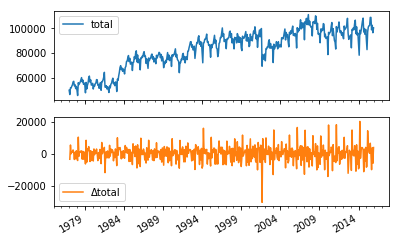

In [21]:
flights.total.to_frame(name='total').assign(Δtotal=lambda x: x.total.diff()).plot(subplots=True)

In [22]:
adftest = smts.adfuller(flights.total.diff().dropna())
dfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in adftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -5.391090
p-value                          0.000004
#Lags Used                      18.000000
Number of Observations Used    448.000000
Critical Value (1%)             -3.445031
Critical Value (5%)             -2.868013
Critical Value (10%)            -2.570218
dtype: float64


With the differenciation of `flights.total`, we can reject the null hypothesis that there is a unit root in the autoregressive model. The alternative hypothesis is stationarity.

Let's fit an [OLS](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html) model of $\Delta total = \beta_0 + \beta_1 L \Delta total_{t-1} + e_t$ and plot the correlation values of the residual.

$\Delta total$ is the differentiaion of the `total` time series, while $L \Delta total_{t-1}$ is the one-month shift of $\Delta total$.

In [23]:
data = (flights.total.to_frame(name='total')
         .assign(Δy=lambda df: df.total.diff())
         .assign(LΔy=lambda df: df.Δy.shift()))
mod_stationary = smfa.ols('Δy ~ LΔy', data=data.dropna())
res_stationary = mod_stationary.fit()

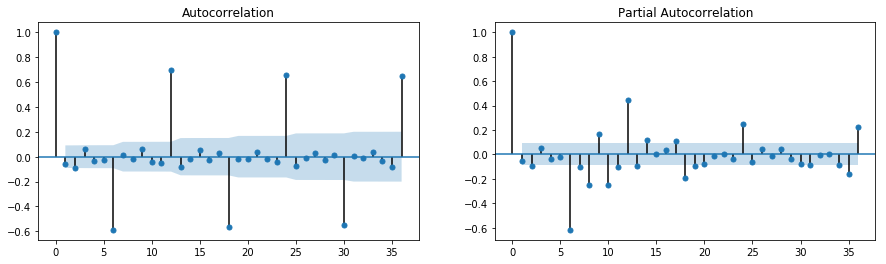

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = smta.graphics.plot_acf(res_stationary.resid, lags=36, ax=axes[0])
fig = smta.graphics.plot_pacf(res_stationary.resid, lags=36, ax=axes[1])

This looks better but we can can observe some spikes every 6 months. 

We still have have to deal with seasonality.

### Seasonality

A picture is worth a thousand words:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa7c4178d0>,
      dtype=object)

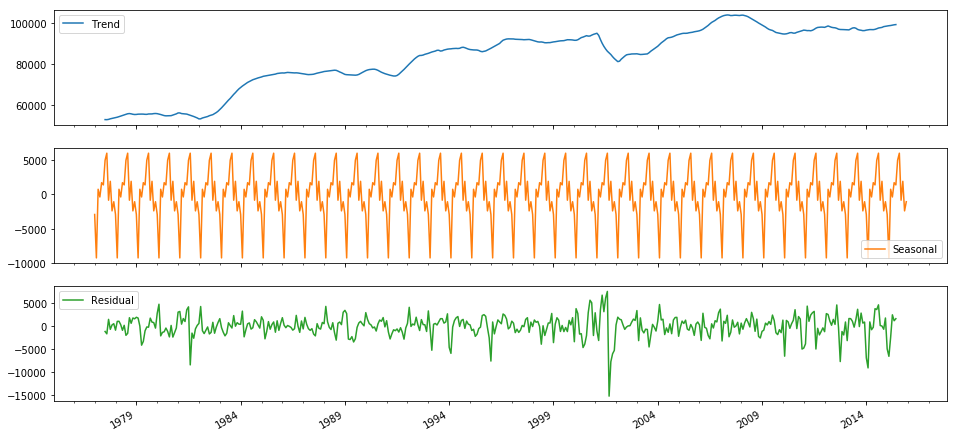

In [25]:
decomp = smta.seasonal_decompose(flights.total, model='additive')
decomp = pd.concat([decomp.trend, decomp.seasonal, decomp.resid, decomp.observed], axis=1)
decomp.columns = ['Trend', 'Seasonal', 'Residual', 'Observed']
decomp[['Trend', 'Seasonal', 'Residual']].plot(subplots=True, figsize=(16, 8))

In order to deal with this seasonal feature, we are going to use the [SARIMAX](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) model: Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model.

The efficient description of the ARIMA family of models by Tom Augspurger could not be shorter:

> So, we've sketched the problems with regular old regression: multicollinearity, autocorrelation, non-stationarity, and seasonality. Our tool of choice, SARIMAX [...] can handle all these. We'll walk through the components in pieces.

> ARIMA stands for AutoRegressive Integrated Moving Average, and it's a relatively simple way of modeling univariate time series. It's made up of three components, and is typically written as $\mathrm{ARIMA}(p, d, q)$.

> ### AutoRegressive

> The idea is to predict a variable by a linear combination of its lagged values (auto-regressive as in regressing a value on its past self). An AR(p), where $p$ represents the number of lagged values used, is written as

> $y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \ldots + \phi_p y_{t-p} + e_t$

>$c$ is a constant and $e_t$ is white noise. This looks a lot like a linear regression model with multiple predictors, but the predictors happen to be lagged values of $y$ (though they are estimated differently).

> ### Integrated

>Integrated is like the opposite of differencing, and is the part that deals with stationarity. If you have to difference your dataset 1 time to get it stationary, then $d=1$. We'll introduce one bit of notation for differencing: $\Delta y_t = y_t - y_{t-1}$ for $d=1$.

> ### Moving Average

>MA models look somewhat similar to the AR component, but it's dealing with different values.

> $y_t = c + e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2} + \ldots + \theta_q e_{t-q}$

> $c$ again is a constant and $e_t$ again is white noise. But now the coefficients are the residuals from previous predictions.

> ### Combining

>Putting that together, an ARIMA(1, 1, 1) process is written as

> $\Delta y_t = c + \phi_1 \Delta y_{t-1} + \theta_t e_{t-1} + e_t$

> Using lag notation, where $L y_t = y_{t-1}$, i.e. y.shift() in pandas, we can rewrite that as

> $(1 - \phi_1 L) (1 - L)y_t = c + (1 + \theta L)e_t$

> That was for our specific $\mathrm{ARIMA}(1, 1, 1)$ model. For the general $\mathrm{ARIMA}(p, d, q)$, that becomes

> $(1 - \phi_1 L - \ldots - \phi_p L^p) (1 - L)^d y_t = c + (1 + \theta L + \ldots + \theta_q L^q)e_t$

> We went through that extremely quickly, so don't feel bad if things aren't clear. Fortunately, the model is pretty easy to use with statsmodels (using it correctly, in a statistical sense, is another matter).

In [26]:
mod = smta.SARIMAX(flights.total, trend='c', order=(1, 1, 1), freq='MS')
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  total   No. Observations:                  468
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4623.616
Date:                Tue, 05 Jun 2018   AIC                           9255.233
Time:                        17:03:20   BIC                           9271.818
Sample:                    01-01-1977   HQIC                          9261.759
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    167.8895    174.739      0.961      0.337    -174.593     510.372
ar.L1         -0.1918      0.092     -2.093      0.036      -0.372      -0.012
ma.L1         -0.2159      0.093     -2.312      0.021      -0.399      -0.033
sigma2      2.284e+07      0.012   1.95e+09      0.000    2.28e+07    2.28e+07
===================================================================================
Ljung-Box (Q):                     1137.31   Jarque-Bera (JB):               216.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.46   Skew:                            -0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.68e+24. Standard errors may be unstable.
"""

> There's a bunch of output there with various tests, estimated parameters, and information criteria. Let's just say that things are looking better, but we still haven't accounted for seasonality.

> A seasonal ARIMA model is written as $\mathrm{ARIMA}(p,d,q)×(P,D,Q)_s$. Lowercase letters are for the non-seasonal component, just like before. Upper-case letters are a similar specification for the seasonal component, where $s$ is the periodicity (4 for quarterly, 12 for monthly).

> It's like we have two processes, one for non-seasonal component and one for seasonal components, and we multiply them together with regular algebra rules. [...] I don't find that to be very clear, but maybe an example will help. We'll fit a seasonal ARIMA$(1,1,2)×(0, 1, 2)_{12}$.

> So the nonseasonal component is

>    $p=1$: period autoregressive: use $y_{t-1}$

>    $d=1$: one first-differencing of the data (one month)

>    $q=2$: use the previous two non-seasonal residual, $e_{t-1}$ and $e_{t-2}$, to forecast

> And the seasonal component is

>    $P=0$: Don't use any previous seasonal values

>    $D=1$: Difference the series 12 periods back: y.diff(12)

>    $Q=2$: Use the two previous seasonal residuals

In [27]:
mod_seasonal = smta.SARIMAX(flights.total, trend='c', freq='MS',
                            order=(1, 1, 2), seasonal_order=(0, 1, 2, 12),
                            simple_differencing=False)
res_seasonal = mod_seasonal.fit(maxiter=200)
res_seasonal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              total   No. Observations:                  468
Model:             SARIMAX(1, 1, 2)x(0, 1, 2, 12)   Log Likelihood               -4271.076
Date:                            Tue, 05 Jun 2018   AIC                           8556.152
Time:                                    17:03:30   BIC                           8584.994
Sample:                                01-01-1977   HQIC                          8567.515
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -41.1474     52.064     -0.790      0.429    -143.191      60.896
ar.L1         -0.9861      0.011    -86.317      0.000      -1.008      -0.964
ma.L1          0.7202      0.036     20.120      0.000       0.650       0.790
ma.L2         -0.2798      0.025    -11.240      0.000      -0.329      -0.231
ma.S.L12      -0.6757      0.029    -23.145      0.000      -0.733      -0.619
ma.S.L24      -0.1203      0.018     -6.610      0.000      -0.156      -0.085
sigma2      8.022e+06   2.18e-06   3.67e+12      0.000    8.02e+06    8.02e+06
===================================================================================
Ljung-Box (Q):                       52.96   Jarque-Bera (JB):              4575.06
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -2.07
Prob(H) (two-sided):                  0.34   Kurtosis:                        17.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.63e+30. Standard errors may be unstable.
"""

Results obtained with the seasonal version of ARIMA look better. 

Let's try to use [pyramid](http://pyramid-arima.readthedocs.io/en/latest/index.html) for automaticly tuning the parameters:

In [28]:
mod_auto = auto_arima(flights.total, 
                      p=1, d=1, q=2,
                      P=0, D=1, Q=2, m=12,
                      trace=True,
                      error_action='ignore',  # don't want to know if an order does not work
                      suppress_warnings=True,  # don't want convergence warnings
                      stepwise=True,
                      maxiter=50)  # set to stepwise
mod_auto.summary()

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 1, 12); AIC=8594.252, BIC=8627.214, Fit time=2.809 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=8788.934, BIC=8797.175, Fit time=0.032 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=8675.517, BIC=8691.999, Fit time=0.264 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=8559.272, BIC=8575.753, Fit time=1.263 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=8555.236, BIC=8575.837, Fit time=1.884 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=8666.178, BIC=8682.660, Fit time=0.240 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=8572.451, BIC=8597.173, Fit time=4.648 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=8746.851, BIC=8759.211, Fit time=0.086 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=8580.279, BIC=8609.121, Fit time=5.897 seconds
Fit ARIMA: order=(1, 1, 1) s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  468
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -4269.313
Date:                            Tue, 05 Jun 2018   AIC                           8550.627
Time:                                    17:04:21   BIC                           8575.349
Sample:                                         0   HQIC                          8560.366
                                            - 468                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -22.2628     28.331     -0.786      0.432     -77.790      33.265
ma.L1         -0.2711      0.024    -11.219      0.000      -0.318      -0.224
ar.S.L12       0.0592      0.036      1.626      0.104      -0.012       0.131
ar.S.L24      -0.1211      0.025     -4.875      0.000      -0.170      -0.072
ma.S.L12      -0.7752      0.041    -18.991      0.000      -0.855      -0.695
sigma2      7.971e+06   2.23e+05     35.753      0.000    7.53e+06    8.41e+06
===================================================================================
Ljung-Box (Q):                       52.46   Jarque-Bera (JB):              4368.85
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -2.07
Prob(H) (two-sided):                  0.44   Kurtosis:                        17.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Not a lot better than what we already got.

### Forecasting

#### One-step ahead forecasts

> At each point (month), we take the history up to that point and make a forecast for the next month. So the forecast for January 2014 has available all the data up through December 2013.

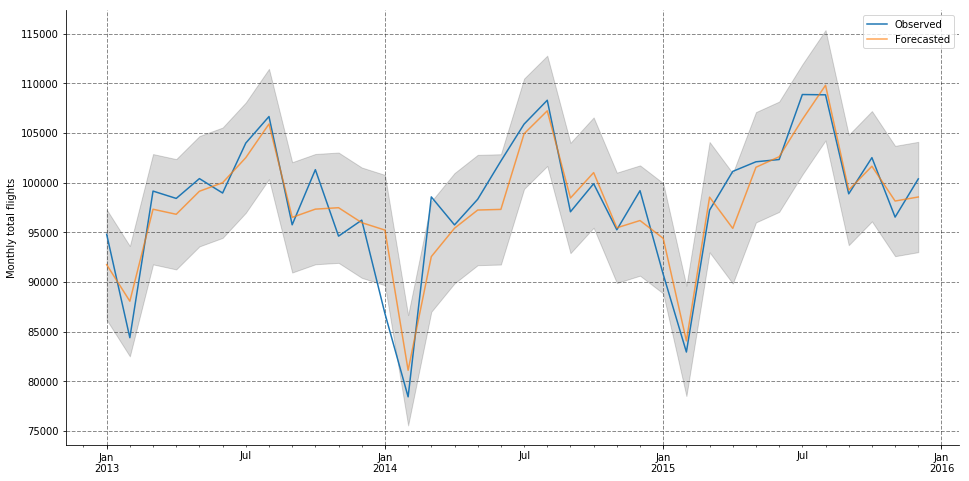

In [29]:
pred = res_seasonal.get_prediction(start='2013-01-01')
pred_ci = pred.conf_int()
ax = flights.total['2013':].plot(label='Observed', figsize=(16, 8))
pred.predicted_mean.plot(ax=ax, label='Forecasted', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.15)
ax.set_ylabel("Monthly total flights")
ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.5)
plt.legend()
sns.despine()

We also plot here the 95% confidence interval of the forecast. We can notice a few times where the observed data goes outside the interval...

#### Dynamic forecasts

> We can make dynamic forecasts as of some month (January 2015 in the example below). That means the forecast from that point forward only use information available as of January 2015. The predictions are generated in a similar way: a bunch of one-step forecasts. Only instead of plugging in the actual values beyond January 2015, we plug in the forecast values.

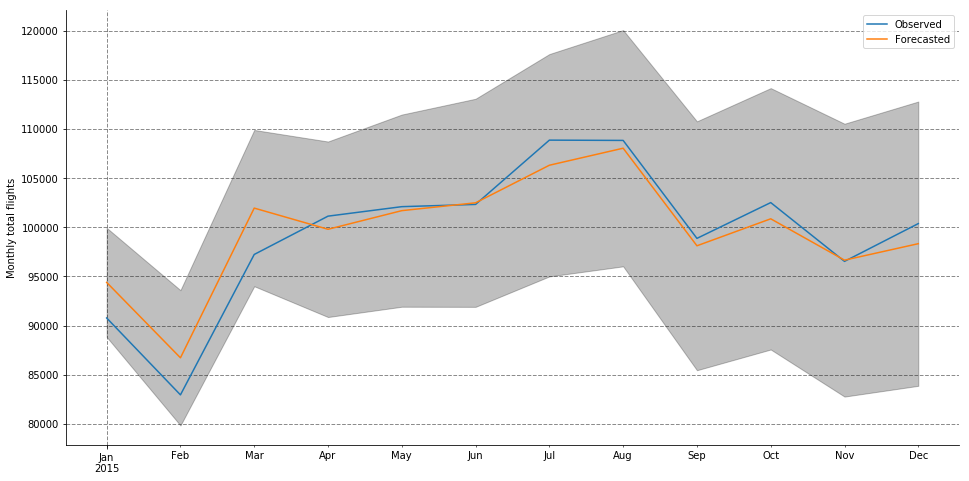

In [30]:
pred_dy = res_seasonal.get_prediction(dynamic='2015-01-01')
pred_dy_ci = pred_dy.conf_int()['2015':]
ax = flights.total['2015':].plot(label='Observed', figsize=(16, 8))
pred_dy.predicted_mean['2015':].plot(ax=ax, label='Forecasted')
ax.fill_between(pred_dy_ci.index,
                pred_dy_ci.iloc[:, 0],
                pred_dy_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_ylabel("Monthly total flights")
ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.5)
plt.legend()
sns.despine()

The observed data are ending at the end of year 2015, but let's try to predict the 2 next years: 2016, 2017.

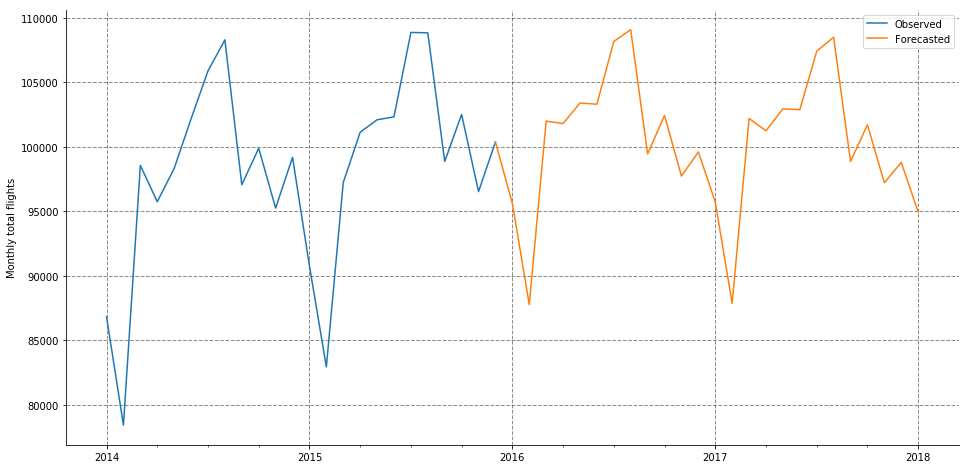

In [31]:
pred_dy = res_seasonal.get_prediction(start='2016-01-01', end='2018-01-01', dynamic=True)
pred_dy_ci = pred_dy.conf_int()['2016':]
ax = flights.total['2014':].plot(label='Observed', figsize=(16, 8))
fc = pred_dy.predicted_mean['2016':].copy(deep=True)
fc = fc.append(flights[datetime(2015, 12, 1):]['total'])
fc.sort_index(inplace=True)
ax = fc.plot(label='Forecasted')
ax.set_ylabel("Monthly total flights")
ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.5)
plt.legend()
sns.despine()